# RNN for Time Series Prediction

This is a time series prediction task. You are given a dataset which reports on the weather and the level of pollution each hour for five years, and asked to train Recurrent Neural Networks (RNNs) to predict the hourly pollution level.

In [1]:
import numpy as np 
import pandas as pd 
from scipy import stats
import math
from datetime import datetime
import matplotlib.pyplot as plt # visualizing data
import seaborn as sns 
from collections import Counter
%matplotlib inline
import pandas_profiling as pP

/home/samer2point3/.local/lib/python3.5/site-packages/pandas_profiling/plot.py:15: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/samer2point3/.local/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/samer2point3/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/samer2point3/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.star

a) Load the data from the file. Perform necessary pre-processing (e.g., missing value replacement, uninformative attribute removal, etc.) and visualise the values of various attributes over the five-year period.

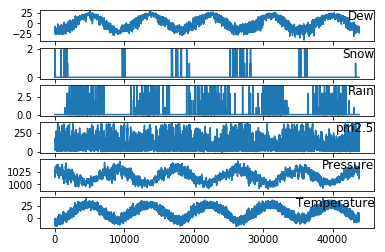

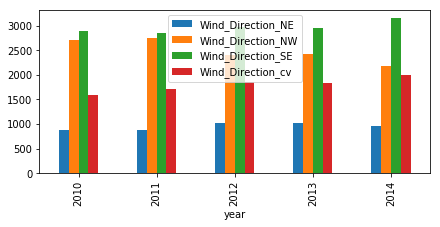

In [16]:
# write your code here

#read file into pandas daraframe
with open('./pollution.csv','r') as DF:
    PD=pd.read_csv(DF)


#drop rows with missing values (consider filling them isntead)
PD['pm2.5']=PD['pm2.5'].fillna(method='bfill')#subset=['pm2.5'],axis=0)
#binary encode catogeric values(wind direction)
PD=pd.get_dummies(PD)
#remove all data points with annomalies (z-score>=3)
PD=PD[(np.abs(stats.zscore(PD)) < 3).all(axis=1)]


#plot the numeric feature vs time
i=1
for attr in ['Dew','Snow','Rain','pm2.5','Pressure','Temperature']:
    plt.subplot(6, 1, i)
    plt.plot(PD[attr])
    plt.title(attr, y=0.5, loc='right')
    i += 1
plt.show()


#group items by year for plotting
yPD=PD.groupby(['year']).sum()
#plot the counts of the different wind direction per year
yPD[['Wind_Direction_NE','Wind_Direction_NW', 'Wind_Direction_SE', 'Wind_Direction_cv']].plot(kind='bar', figsize=(7,3))
#pP.ProfileReport(AD)


b) Frame the task as the supervised learning problem as predicting the pollution at the current hour given the pollution measurement and weather conditions at the previous hour. Using the first 4 years' data as the training set and the remaining 1 year's data as the test set. Prepare the training/test sets accordingly.

In [17]:
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import copy
# write your code here

#function takes the number of timesteps(t) and the pollution datarame and returns correctly 
#formatted x and y for the LSTM input
def prep(t, PD):
    #save the train and test size by counting the  samples in year 2014
    train_size=PD[PD['year']!=2014].shape[0]-t
    test_size=PD[PD['year']==2014].shape[0]-t-1
    nfeat=11 #no of features used
    
    #drop the unnecassary features
    PD.drop(columns=['year','month','day','hour','No'], inplace=True)
    
    #create a timeseries dataframe by concatenating it to a shifted version of itself 
    tempPD=PD
    pmPlus=PD['pm2.5'].shift(-t) #shift the output by the desired timestep and save it
    pmPlus.name='yt+1'
    for i in range(1,t):
        PD=pd.concat([PD,tempPD.shift(-i)], axis=1) #concat a shifted version of the input for each timestep
    
    #drop the first and last t samples
    PD=pd.concat([PD,pmPlus], axis=1)
    PD.drop(index=PD.index[:t], inplace=True)
    PD.drop(index=PD.index[PD.shape[0]-t-1:], inplace=True)
                      

    #fill missing values with the last valid value
    PD=PD.fillna(method='ffill')
    #split in to training and testing 
    train_PD=PD.iloc[0:train_size]
    test_PD=PD.iloc[train_size:]

    #save the  the maximum and minimum values of output
    minmax=[PD['yt+1'].min(),PD['yt+1'].max()]
    #tranform input and output into numpy arrays and scale them to 0 - 1
    scaler=MinMaxScaler()
    train_x=scaler.fit_transform(train_PD.drop(columns=['yt+1']).values)
    test_x=scaler.fit_transform(test_PD.drop(columns=['yt+1']).values)
    
    train_y=scaler.fit_transform(train_PD['yt+1'].values.reshape(-1,1))
    test_y=scaler.fit_transform(test_PD['yt+1'].values.reshape(-1,1))
    
    #save dataset sizes
    train_x=train_x.reshape(train_size,t,nfeat)
    test_x=test_x.reshape(test_size,t,nfeat)
    
    #use 10% of the training dataset as validation
    valid_size=train_x.shape[0]*1//10
    valid_x=train_x[:valid_size]
    valid_y=train_y[:valid_size]
    train_x=train_x[valid_size:]
    train_y=train_y[valid_size:]
    
    #return minmax and training, validation, and testing datsets
    return minmax, train_x, train_y, valid_x, valid_y, test_x, test_y

t=1
minmax,train_x, train_y, valid_x, valid_y, test_x, test_y=prep(t,copy.deepcopy(PD))

c) Train a Recurrent Neural Network (RNN) on the training set. You can split the training set further by using 10% of the data as the validation set and the remaining for training.

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30)                5040      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 5,071
Trainable params: 5,071
Non-trainable params: 0
_________________________________________________________________
Train on 29455 samples, validate on 3272 samples
Epoch 1/20
 - 4s - loss: 0.0589 - val_loss: 0.0429
Epoch 2/20
 - 3s - loss: 0.0341 - val_loss: 0.0386
Epoch 3/20
 - 3s - loss: 0.0338 - val_loss: 0.0385
Epoch 4/20
 - 3s - loss: 0.0338 - val_loss: 0.0385
Epoch 5/20
 - 2s - loss: 0.0337 - val_loss: 0.0378
Epoch 6/20
 - 2s - loss: 0.0337 - val_loss: 0.0377
Epoch 7/20
 - 2s - loss: 0.0336 - val_loss: 0.0378
Epoch 8/20
 - 3s - loss: 0.0336 - val_loss: 0.0382
Epoch 9/20
 - 3s - loss: 0.0336 - val_loss: 0.0372
Epoch 10/20
 - 2s - loss: 0.

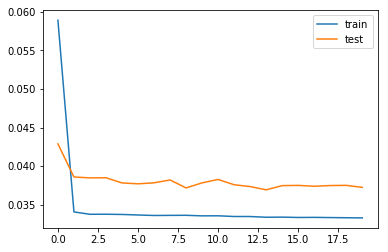

In [5]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, Dropout, Masking
# write your code here

#create network with one layer of LSTM 
model = Sequential()
model.add(LSTM(30,input_shape=(t, train_x.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
model.summary()
history = model.fit(train_x, train_y, epochs=20, batch_size=32, validation_data=(valid_x, valid_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

d) Output the prediction results such as Root Mean Squared Errors (RMSE) on the test set. Remember that after the forecasts have been made, we need to invert the transforms to return the values back into the original scale. This is needed so that we can calculate error scores and plots that are comparable with other models. Plot the predicted values vs. the actual values.

22.50924388233408


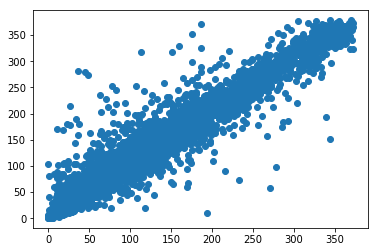

In [6]:
from sklearn.metrics import mean_squared_error

# write your code here

#use th trained model to predict pollution
pred_y=model.predict(test_x)
#use minimum and maximum values to return output to the original scale
tr_test_y=minmax[0]+test_y*(minmax[1]-minmax[0])
tr_pred_y=minmax[0]+pred_y*(minmax[1]-minmax[0])

#scatter plot prediciton vs  actual pollution levels
plt.scatter(tr_test_y, tr_pred_y)
#output the root mean square error of the predicitons 
RMSE=math.sqrt(mean_squared_error(tr_pred_y,tr_test_y))
print(RMSE)

e) Explore different network architectures (e.g., stacked LSTM layers) and various ways in tuning the model parameters to see if you can improve the model performance on the test set. 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_53 (LSTM)               (None, 1, 25)             3700      
_________________________________________________________________
lstm_54 (LSTM)               (None, 25)                5100      
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 26        
Total params: 8,826
Trainable params: 8,826
Non-trainable params: 0
_________________________________________________________________
Train on 29455 samples, validate on 3272 samples
Epoch 1/20
 - 14s - loss: 0.0654 - val_loss: 0.0495
Epoch 2/20
 - 4s - loss: 0.0347 - val_loss: 0.0398
Epoch 3/20
 - 4s - loss: 0.0340 - val_loss: 0.0398
Epoch 4/20
 - 5s - loss: 0.0339 - val_loss: 0.0392
Epoch 5/20
 - 4s - loss: 0.0339 - val_loss: 0.0407
Epoch 6/20
 - 4s - loss: 0.0339 - val_loss: 0.0404
Epoch 7/20
 - 4s - loss: 0.0339 - val_loss: 0.04

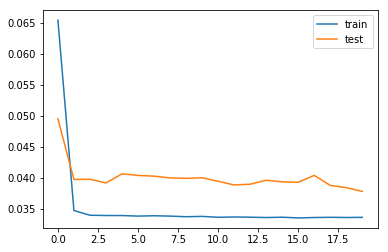

22.881349347315133


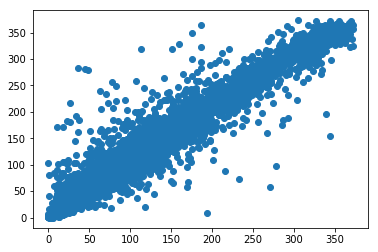

In [33]:
# write your code here

#create network with 2 layers of LSTM
model = Sequential()
model.add(LSTM(25,input_shape=(t, train_x.shape[2]), return_sequences=True))
model.add(LSTM(25))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
model.summary()
history = model.fit(train_x, train_y, epochs=20, batch_size=32, validation_data=(valid_x, valid_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

#use th trained model to predict pollution
pred_y=model.predict(test_x)
#use minimum and maximum values to return output to the original scale
tr_test_y=minmax[0]+test_y*(minmax[1]-minmax[0])
tr_pred_y=minmax[0]+pred_y*(minmax[1]-minmax[0])

#scatter plot prediciton vs  actual pollution levels
plt.scatter(tr_test_y, tr_pred_y)
#output the root mean square error of the predicitons 
RMSE=math.sqrt(mean_squared_error(tr_pred_y,tr_test_y))
print(RMSE)

f) Explore alterative prediction setup by predicting the pollution for the next hour based on the weather conditions and pollution over the last 3 days.

21.330035321295888


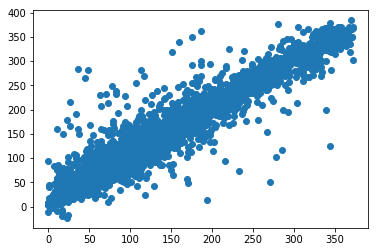

In [36]:
# write your code here
n_steps=24*3
minmax,train_x, train_y, valid_x, valid_y, test_x, test_y=prep(n_steps,copy.deepcopy(PD))
     
#creatae a sequential network with one LSTM layer
model = Sequential()
model.add(LSTM(50,input_shape=(n_steps, train_x.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
model.summary()
history = model.fit(train_x, train_y, epochs=20, batch_size=32, validation_data=(valid_x, valid_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


pred_y=model.predict(test_x)
#use minimum and maximum values to return output to the original scale
tr_test_y=minmax[0]+test_y*(minmax[1]-minmax[0])
tr_pred_y=minmax[0]+pred_y*(minmax[1]-minmax[0])
#scatter plot prediciton vs  actual pollution levels
plt.scatter(tr_test_y, tr_pred_y)
#output the root mean square error of the predicitons 
RMSE=math.sqrt(mean_squared_error(tr_pred_y,tr_test_y))
print(RMSE)